데이터를 훈련 세트와 테스트 세트로 나누는 이유는 지금까지 본 적 없는 새로운 데이터에 모델이 얼마나 잘 일반화되는지 측정하기 위해서이다.

5장에서는 두 가지 관점에서 이 평가 방법을 확장해보겠다.
1. 먼저 안정적인 일반화 성능 측정 방법인 교차 검증을 소개하고,
2. score 메서드가 제공하는 정확도와 R^2 값 이외에 분류와 회귀 성능을 측정하는 다른 방법을 알아보겠다.
3. 지도 학습 모델의 매개변수를 조정하는 데 유용한 그리드 서치에 관하여

# 5.1 교차 검증(Cross-validation)
교차 검증에서는 데이터를 여러 번 반복해서 나누고 여러 모델을 학습한다. 

가장 널리 사용되는 교차 검증 방법 'k-fold 교차 검증'
- k는 보통 5 또는 10
- fold: 크기가 거의 비슷한 '부분 집합'
    + 첫 번째 모델은 첫 번째 폴드를 테스트 세트로 사용하고 나머지 (2~5)를 훈련 세트로 사용하여 학습
    + 두 번째 모델은 두 번째 폴드를 테스트 세트로 사용하고 나머지 (1,3,4,5)를 훈련 세트로 사용하여 학습
    + ....

In [1]:
import mglearn
mglearn.plots.plot_cross_validation()

C:\Anaconda\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# 5.1.1 scikit-learn의 교차 검증

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

scores = cross_val_score(logreg, iris.data, iris.target) #fold =3
print('Cross Validation Score: ', scores)

Cross Validation Score:  [0.96078431 0.92156863 0.95833333]


In [4]:
scores = cross_val_score(logreg, iris.data, iris.target, cv=5)
print('Cross Validation Score: ', scores)

Cross Validation Score:  [1.         0.96666667 0.93333333 0.9        1.        ]


In [5]:
print('Mean of Cross Validation Scores: {:.2f}'.format(scores.mean()))

Mean of Cross Validation Scores: 0.96


교차 검증 평균값으로 이 모델의 정확도가 대략 96%일 것으로 기대할 수 있다.  
교차 검증에 `cross-validate` 함수를 사용할 수도 있다. 이 함수는 `cross_val_score` 함수와 인터페이스가 비슷하지만 분할마다 훈련과 테스트에 걸린 시간을 담은 딕셔너리를 반환한다.

In [6]:
from sklearn.model_selection import cross_validate
res = cross_validate(logreg, iris.data, iris.target, cv=5, return_train_score = True)
display(res)

{'fit_time': array([0.00199795, 0.00399113, 0.00199842, 0.00299883, 0.00099897]),
 'score_time': array([0.        , 0.00101161, 0.0010004 , 0.        , 0.        ]),
 'test_score': array([1.        , 0.96666667, 0.93333333, 0.9       , 1.        ]),
 'train_score': array([0.95      , 0.96666667, 0.96666667, 0.975     , 0.95833333])}

In [7]:
import pandas as pd

res_df = pd.DataFrame(res)
display(res_df)
print('Average time and Score: \n', res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.001998,0.000000,1.000000,0.950000
1,0.003991,0.001012,0.966667,0.966667
2,0.001998,0.001000,0.933333,0.966667
3,0.002999,0.000000,0.900000,0.975000
4,0.000999,0.000000,1.000000,0.958333


Average time and Score: 
 fit_time       0.002397
score_time     0.000402
test_score     0.960000
train_score    0.963333
dtype: float64


# 5.1.2 교차 검증의 장점
1. train_test_split과의 비교
    - train_test_split은 데이터를 무작위로 나눈다. 이때 운 좋게 훈련 세트에는 분류하기 어려운 샘플만 담기게 되었다고 생각해보자. 이 경우 테스트 세트에는 분류하기 쉬운 샘플만 들어 있어서 테스트 세트의 정확도는 비현실적으로 높게 나올 것이다.  
    - 반대로 운 나쁘게 분류하기 어려운 샘플들이 모두 테스트 세트에 들어간다면 정확도가 아주 낮게 나올 것이다.
    - 그러나 교차 검증을 사용하면 테스트 세트에 각 샘플이 정확하게 한 번씩 들어간다. 그렇기 때문에 교차 검증의 점수를 높이기 위해서는 데이터셋에 잇는 모든 샘플에 대해 모델이 잘 일반화되어야 한다.
2. 모델이 훈련 데이터에 얼마나 민감한지 알 수 있다.
    - cross-validation을 한 iris 데이터셋에서 90~100%의 정확도를 얻었다. 이 범위는 꽤 넓으며 새로운 데이터를 적용했을 때 최악의 경우와 최선의 경우를 짐작할 수 있다.
3. 데이터를 더 효과적으로 사용할 수 있다.
    - 많은 데이터는 보통 더 정확한 모델을 만들어낸다. 

<br><br/>
**NOTE**  
교차 검증 함수는 모델을 반환하지 않는다. 단지 평가 수단일 뿐.


# 5.1.3 계층별 k-fold 교차 검증과 그외 전략들

In [8]:
#데이터셋을 나열 순서대로 k개의 폴드로 나누는 것이 항상 좋은 것만은 아니다
from sklearn.datasets import load_iris
iris = load_iris()

print('Iris label:\n', iris.target)

Iris label:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


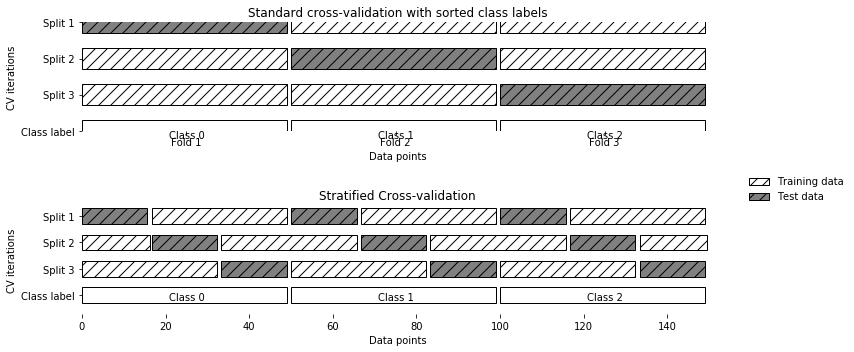

In [9]:
#데이터 라벨이 순서대로 30%씩 나열되어있기 때문에 이 상태로 k-fold하면 교차 검증의 정확도는 0이 될 것.
##계층별 k-fold 교차 검증을 사용하자.
mglearn.plots.plot_stratified_cross_validation()

## 교차 검증 상세 옵션

In [10]:
#다른 사람의 결과를 재현하기 위해 분류 데이터셋에 기본 k-겹 교차 검증을 사용해야 할 때
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5)
print('Cross Validation Scores:\n', cross_val_score(logreg, iris.data, iris.target, cv=kfold))

Cross Validation Scores:
 [1.         0.93333333 0.43333333 0.96666667 0.43333333]


In [11]:
kfold = KFold(n_splits=3)
print('Cross Validation Scores:\n', cross_val_score(logreg, iris.data, iris.target, cv=kfold))
#아무것도 학습할 수가 없다.

Cross Validation Scores:
 [0. 0. 0.]


In [12]:
#shuffle = True 추가
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
print('Cross Validation Scores:\n', cross_val_score(logreg, iris.data, iris.target, cv=kfold))

Cross Validation Scores:
 [0.9  0.96 0.96]


## LOOCV(Leave-one-out cross-validation)
교차 검증 방법 중 하나. 폴드 하나에 샘플 하나만 들어 있는 k-fold 교차 검증으로 생각할 수 있다.  
각 반복에서 하나의 데이터 포인트를 선택해 테스트 세트로 사용한다.  
데이터셋이 클 때는 시간이 매우 오래 걸리지만 작은 데이터셋에서는 이따금 더 좋은 결과를 만들어낸다.

In [13]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
scores = cross_val_score(logreg, iris.data, iris.target, cv=loo)

print('교차 검증 분할 횟수: ', len(scores))
print('평균 정확도 : {:.2f}'.format(scores.mean()))

교차 검증 분할 횟수:  150
평균 정확도 : 0.95


## 임의 분할 교차 검증
train_size만큼의 포인트로 훈련 세트를 만들고, test_size만큼의 (훈련세트와 중첩되지 않은) 포인트로 테스트 세트를 만들도록 분할한다.  
이 분할은 n_splits 횟수만큼 반복된다.

반복 횟수를 훈련 세트나 테스트 세트의 그기와 독립적으로 조절해야할 때 유용하다.  
또한 전체 데이터의 일부만 사용하는 부분 샘플링(subsampling)하는 방식은 대규모 데이트셋으로 작업할 때 도움이 된다.  

ShuffleSplit의 계층별 버전으로 분류 작업에 더 적합한 StratifiedShuffleSplit도 있다.

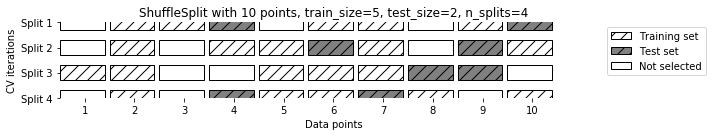

In [14]:
mglearn.plots.plot_shuffle_split()

In [15]:
#데이터셋의 50%를 훈련 세트로, 50%를 테스트 세트로 10번 반복 분할하는 예제
from sklearn.model_selection import ShuffleSplit

shuffle_split = ShuffleSplit(test_size=.5, train_size=.5, n_splits=10)
scores = cross_val_score(logreg, iris.data, iris.target, cv=shuffle_split)

print('Cross Validation Score:\n', scores)

Cross Validation Score:
 [0.96       0.89333333 0.96       0.93333333 0.81333333 0.92
 0.98666667 0.93333333 0.97333333 0.93333333]


## 그룹별 교차 검증
데이터 안에 매우 연관된 그룹이 있을 때도 교차 검증을 널리 사용한다.  
예를 들어 얼굴 사진에서 표정을 인식하는 시스템을 만들 때 훈련 세트와 테스트 세트에 서로 다른 사람의 사진이 들어가도록 해야 한다.  
이를 위해 사진의 사람이 누구인지 기록한 배열을 groups 매개변수로 전달받을 수 있는 GroupKFold를 사용할 수 있다.  
groups 배열은 훈련 세트와 테스트 세트를 만들 때 분리되지 않아야 할 그룹을 지정하는 것이며, 클래스 레이블과 혼동해서는 안된다. 

In [16]:
from sklearn.model_selection import GroupKFold
from mglearn.datasets import make_blobs

#인위적 데이터셋 생성
X, y = make_blobs(n_samples=12, random_state=0)

#처음 세 개의 샘플은 같은 그룹에 속하고
#다음 네 개의 샘플이 같다.
groups = [0,0,0,1,1,1,1,2,2,3,3,3]
scores = cross_val_score(logreg, X, y, groups, cv=GroupKFold(n_splits=3))
print('Cross Validation Score:\n', scores)

Cross Validation Score:
 [1.  0.8 1. ]


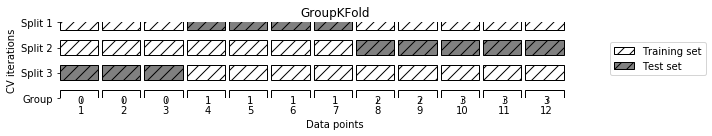

In [17]:
mglearn.plots.plot_group_kfold()

# 5.1.4 반복 교차 검증
데이터셋의 크기가 크지 않을 경우 안정된 검증 점수를 얻기 위해 교차 검증을 반복하여 여러 번 수행하는 경우가 많다.  
이를 위해 scikit-learn 0.19 버전에서 RepeatedKFold와 RepeatedStratifiedKFold 분할기가 추가되었다. 이를 cv 매개변수에 전달하여 교차 검증을 반복할 수 있다. 

회귀에는 RepeatedKFold를 사용하고 분류에는 RepeatedStratifiedKFold를 사용한다.

In [18]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression

iris = load_iris()
logreg = LogisticRegression()

rskfold = RepeatedStratifiedKFold(random_state=42)
scores = cross_val_score(logreg, iris.data, iris.target, cv=rskfold)

print('Cross Val Score:\n', scores)
print('Mean of Cross Val Score: {:.3f}'.format(scores.mean()))

Cross Val Score:
 [0.96666667 0.96666667 0.96666667 0.93333333 0.96666667 0.86666667
 0.96666667 0.96666667 0.93333333 0.96666667 1.         1.
 0.93333333 0.93333333 0.93333333 1.         0.96666667 0.96666667
 0.9        0.96666667 0.96666667 0.96666667 1.         0.9
 0.96666667 0.93333333 1.         0.96666667 0.96666667 0.93333333
 0.96666667 0.93333333 0.96666667 0.96666667 0.96666667 0.96666667
 0.93333333 0.93333333 0.96666667 1.         0.96666667 0.96666667
 0.86666667 1.         0.93333333 1.         0.96666667 1.
 0.93333333 0.9       ]
Mean of Cross Val Score: 0.957


# 5.2 그리드 서치
모델의 일반화 성능을 최대로 높여주는 매개변수의 값을 찾는 일은 매우 중요하다.  
관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도해보는 것 = '그리도 서치'

# 5.2.1 간단한 그리드 서치

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)
print('X_train.shape: {}, X_test.shape {}'.format(X_train.shape, X_test.shape))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        #매개변수의 각 조합에 대해 SVC를 훈련시킨다.
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        
        score = svm.score(X_test, y_test)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}
            
            
print('Best Score: {:.2f}'.format(best_score))
print('Best Paraameters:', best_parameters)

X_train.shape: (112, 4), X_test.shape (38, 4)
Best Score: 0.97
Best Paraameters: {'C': 100, 'gamma': 0.001}


여러 가지 매개변수 값으로 많이 시도해보고 테스트 세트 정확도가 가장 높은 조합을 선택했다. 하지만 이 정확도는 새로운 데이터에까지 이어지지 않을 수 있다.  
매개변수를 조정하기 위해 테스트 세트를 이미 사용했기 때문에 모델이 얼마나 좋은지 평가하는 데는 더 이상 사용할 수 없다.  
즉, 평가를 위해서는 모델을 만들 때 사용하지 않은 독립된 데이터셋이 필요하다. 

# 5.2.2 매개변수 과대적합과 검증 세트
데이터를 세 개의 세트로 만들어 위에 발생한 문제를 해결할 수 있다.  
훈련 세트로는 모델을 만들고, 검증 세트로는 모델의 매개변수를 선택하고, 테스트 세트로는 선택된 매개변수의 성능을 평가한다.

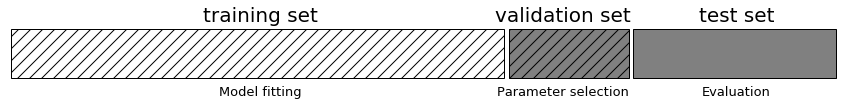

In [20]:
mglearn.plots.plot_threefold_split()

In [21]:
#검증 세트를 사용해 최적의 매개변수를 선택한 후
##그 매개변수에서 훈련 세트와 검증 세트 데이터를 모두 이용해 모델을 다시 만든다.
from sklearn.svm import SVC
X_trainval, X_test, y_trainval, y_test = train_test_split(iris.data, iris.target, random_state=0)
#다시 분할
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, random_state=1)

print('X_train.shape: {}, X_val.shape: {}, X_test.shape: {}\n'.format(X_train.shape, X_val.shape, X_test.shape))

X_train.shape: (84, 4), X_val.shape: (28, 4), X_test.shape: (38, 4)



In [22]:
best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        #매개변수의 각 조합에 대해 SVC를 훈련시킨다.
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        
        score = svm.score(X_val, y_val)  #이전과 달라진 부분
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

In [23]:
#훈련 세트와 검증 세트를 합쳐 모델을 다시 만든 후
##테스트 세트를 사용해 평가하기
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)

print('Best Score in Validation set: {:.2f}'.format(best_score))
print('Best Parameters: ', best_parameters)
print('Test Score in Best Parmameters: {:.2f}'.format(test_score))

Best Score in Validation set: 0.96
Best Parameters:  {'C': 10, 'gamma': 0.001}
Test Score in Best Parmameters: 0.92


테스트 세트 정확도에 기초해 어떤 선택을 했다면 테스트 세트의 정보를 모델에 누설한 것이다.  
그렇기 때문에 최종 평가에만 사용하도록 테스트 세트를 분리해 유지하는 것이 중요하다.  
모든 탐색적 분석과 모델 선택을 위해서는 훈련 세트와 검증 세트를 사용하는 것을 권장한다.

# 5.2.3 교차 검증을 사용한 그리드 서치
일반화 성능을 더 잘 평가하려면 훈련 세트와 검증 세트를 한 번만 나누지 않고, 교차 검증을 사용해서 각 매개변수 조합의 성능을 평가할 수 있다.

In [24]:
import numpy as np

best_score = 0
for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        #매개변수의 각 조합에 대해 SVC를 훈련시킨다.
        svm = SVC(gamma=gamma, C=C)
        #교차 검증을 적용
        scores = cross_val_score(svm, X_trainval, y_trainval, cv=5)
        #교차 검증 정확도의 평균을 계산
        score = np.mean(scores)
        
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

#훈련 세트와 검증 세트를 합쳐 모델을 다시 만든다.
svm= SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)

print('Best Score in Validation set: {:.2f}'.format(best_score))
print('Best Parameters: ', best_parameters)
print('Test Score in Best Parmameters: {:.2f}'.format(test_score))

Best Score in Validation set: 0.97
Best Parameters:  {'C': 100, 'gamma': 0.01}
Test Score in Best Parmameters: 0.92


5-겹 교차 검증으로 C와 gamma 설정에 대한 SVM의 정확도를 평가하려면 (6\*6)\*5 = 180 개의 모델을 만들어야한다.  
이는 곧 모델을 모두 학습시키는 데 걸리는 시간이다.

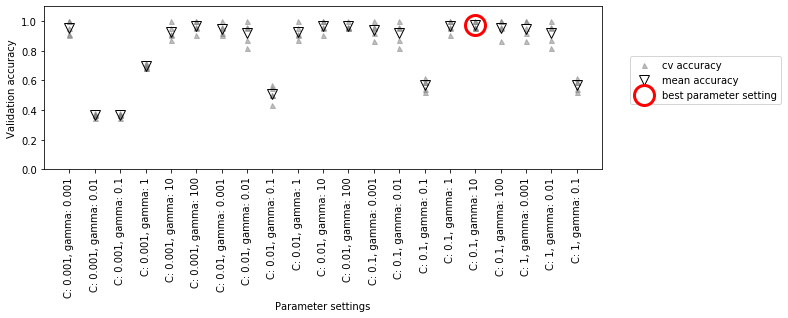

In [25]:
mglearn.plots.plot_cross_val_selection()

각 매개변수 설정마다 교차 검증 분할에 한 개씩, 모두 다섯 개의 값을 계산한다. 교차 검증 정확도 평균이 가장 높은 매개변수를 동그라미로 표시했다.  
교차 검증은 그리드 서치와 같은 매개변수 탐색 방법과 합쳐서 많이 사용한다.

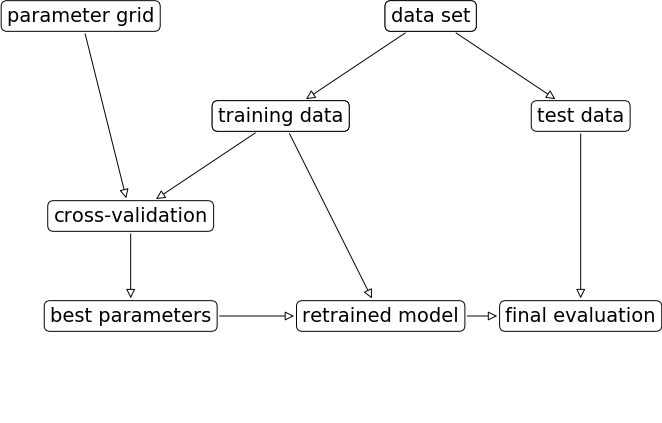

In [26]:
mglearn.plots.plot_grid_search_overview()

교차 검증을 사용한 그리드 서치를 매개변수 조정 방법으로 널리 사용하기 때문에 scikit-learn에서는 추정기 형태로 구현된 GridSearchCV를 제공한다.
1. 딕셔너리 형태로 검색 대상 매개변수를 지정한다. 딕셔너리의 키는 조정하고자 하는 매개변수 이름이고, 값은 탐색할 매개변수의 설정값이다.
2. 모델, 검색 대상 매개변수 그리드, 원하는 교차 검증으로 GridSearchCV 객체를 생성한다.

In [27]:
param_grid = {'C' :[0.001,0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
print('매개변수 그리드:\n', param_grid)

매개변수 그리드:
 {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=0)

grid_search.fit(X_train, y_train) #fit 메서드를 호출하면 param_grid에 설정된 매개변수 조합에 대한 교차 검증을 수행한다.

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

fit 메서드는 최적의 매개변수를 찾는 일뿐만 아니라, 교차 검증 성능이 가장 좋은 매개변수로 전체 훈련 데이터셋에 대해 새로운 모델을 자동으로 생성한다.
GridSearchCV는 전체 데이터로 학습한 모델에 접근할 수 있도록 predict와 score 메서드를 제공한다.

In [29]:
print('Test Score: {:.2f}'.format(grid_search.score(X_test, y_test))) #전체 훈련 세트에서 학습한 모델에 대한 것
print('Best Parameters: ', grid_search.best_params_)
print('Best Cross Validation Score: {:.2f}'.format(grid_search.best_score_)) #훈련세트에서 수행한 교차 검증의 평균 정확도

Test Score: 0.97
Best Parameters:  {'C': 100, 'gamma': 0.01}
Best Cross Validation Score: 0.97


In [30]:
print('Best Model: \n', grid_search.best_estimator_) #최고 성능 모델

Best Model: 
 SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


## 교차 검증 결과 분석
그리드 서치는 연산 비용이 매우 크므로 비교적 간격을 넓게 하여 적은 수의 그리드로 시작하는 것이 좋다.  
그런 다음 교차 검증된 그리드 서치의 결과를 분석하여 검색을 확장해나갈 수 있다.

그리드 서치의 결과는 검색과 관련한 여러 정보가 함께 저장되어 있는 딕셔너리인 cv_results_ 속성에 담겨 있다.

In [31]:
pd.set_option('display.max_columns', None)
results = pd.DataFrame(grid_search.cv_results_)

#처음 다섯 개 행을 출력
display(np.transpose(results.head()))

,0,1,2,3,4
mean_fit_time,0.00159736,0.00160065,0.000999451,0.00139947,0.00179973
std_fit_time,0.000488306,0.000799438,2.61174e-07,0.000489824,0.000400261
mean_score_time,0.00100088,0.000602245,0.00019989,0.00100174,0.000399971
std_score_time,0.00109667,0.000491751,0.00039978,0.000635279,0.000489863
param_C,0.001,0.001,0.001,0.001,0.001
param_gamma,0.001,0.01,0.1,1,10
params,"{'C': 0.001, 'gamma': 0.001}","{'C': 0.001, 'gamma': 0.01}","{'C': 0.001, 'gamma': 0.1}","{'C': 0.001, 'gamma': 1}","{'C': 0.001, 'gamma': 10}"
split0_test_score,0.375,0.375,0.375,0.375,0.375
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826
split2_test_score,0.363636,0.363636,0.363636,0.363636,0.363636


In [32]:
np.array(results.mean_test_score).reshape(6,6)

array([[0.36607143, 0.36607143, 0.36607143, 0.36607143, 0.36607143,
        0.36607143],
       [0.36607143, 0.36607143, 0.36607143, 0.36607143, 0.36607143,
        0.36607143],
       [0.36607143, 0.69642857, 0.91964286, 0.95535714, 0.36607143,
        0.36607143],
       [0.69642857, 0.92857143, 0.96428571, 0.94642857, 0.91964286,
        0.50892857],
       [0.92857143, 0.96428571, 0.96428571, 0.9375    , 0.91964286,
        0.57142857],
       [0.96428571, 0.97321429, 0.95535714, 0.94642857, 0.91964286,
        0.57142857]])

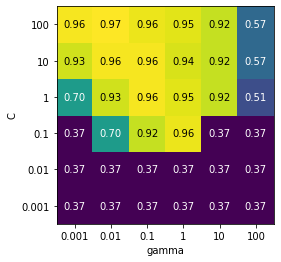

In [33]:
scores = np.array(results.mean_test_score).reshape(6,6)

mglearn.tools.heatmap(scores, xlabel='gamma', xticklabels = param_grid['gamma'], ylabel='C', yticklabels=param_grid['C'],
                     cmap='viridis')

###### 검색 범위가 적절하게 선택되지 않아서 바람직하지 못한 결과를 내는 그래프 예

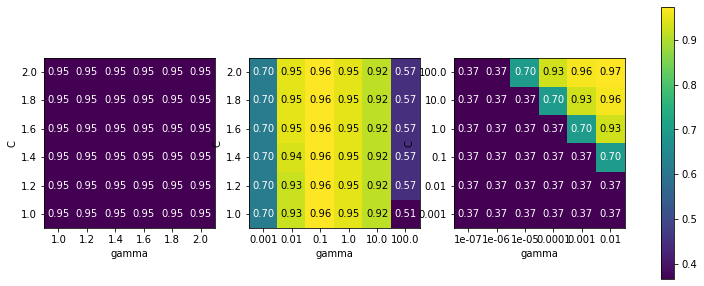

In [34]:
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,3, figsize = (13,5))

param_grid_linear = {'C': np.linspace(1,2,6), 'gamma': np.linspace(1,2,6)}

param_grid_one_log = {'C': np.linspace(1,2,6), 'gamma': np.logspace(-3,2,6)}

param_grid_range = {'C' : np.logspace(-3,2,6), 'gamma': np.logspace(-7,-2,6)}

for param_grid, ax in zip([param_grid_linear, param_grid_one_log, param_grid_range], axes):
    grid_search = GridSearchCV(SVC(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    scores = grid_search.cv_results_['mean_test_score'].reshape(6,6)
    
    #교차 검증 평균 점수의 히트맵 그래프
    scores_image = mglearn.tools.heatmap(scores, xlabel='gamma', ylabel='C', xticklabels=param_grid['gamma'],
                                        yticklabels=param_grid['C'], cmap='viridis', ax=ax)

plt.colorbar(scores_image, ax=axes.tolist())

1. 첫 번째 그리드:
    - 첫 번째 그리드는 점수 변화가 전혀 없어서 전체 매개변수 그리드가 같은 색이다. 
    - 이런 결과는 매개변수 C와 gamma의 스케일과 범위가 부적절할 때 발생한다. 
    - 그러나 매개변수 설정이 바뀌어도 정확도에 아무런 변화가 없다면, 그 매개변수가 전혀 중요하지 않은 것일 수도 있다. 
    - 처음에는 매우 극단적인 값을 적용해보고, 매개변수를 바꿔가며 정확도가 변핮는지 살펴보는 것이 좋다.
2. 두 번째 그리드:
    - 세로 띠 형태를 보인다.
    - 이는 gamma 매개변수만 정확도에 영향을 준다는 뜻이다.
    - 즉, gamma 매개변수는 적절한 범위를 탐색하고 있지만 C 매개변수는 그렇지 못하든지, 아니면 중요한 매개변수가 아닐 수도 있다.
3. 세 번째 그리드:
    - C와 gamma 둘 모두에 따라 값이 변했다.
    - 하지만 그래프의 왼쪽 아래 영역에서는 아무런 변화가 없다. 
    - 최적치가 그래프의 경계에 있으니 이 경계 너머에 더 나은 값이 있다고 생각할 수 있다. 그러니 이 영역이 포함되도록 매개변수 검색 범위를 바꿔줘야 한다. 

## 비대칭 매개변수 그리드 탐색
어떤 경우에는 모든 매개변수의 조합에 대해 GridSearchCV를 수행하는 것이 좋지 않을 수 있다.  
예를 들어 SVC는 kernel에 따라 관련 있는 매개변수들이 결정된다. kernel='linear'이면 선형 모델로 C 매개변수만 사용하고, kernel='rbf'이면 C와 gamma를 모두 사용한다.

이런 조건부 매개변수 조합을 적용하려면 GridSearchCV에 전달할 param_grid를 딕셔너리의 리스트로 만들어주면 된다.

In [35]:
param_grid = [{'kernel': ['rbf'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'kernel': ['linear'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100]}]

print('그리드 목록:\n', param_grid)

그리드 목록:
 [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}, {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100]}]


In [36]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

print('Best Parameter: ', grid_search.best_params_)
print('Best Cross Validation Score: {:.2f}'.format(grid_search.best_score_))

Best Parameter:  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best Cross Validation Score: 0.97


In [37]:
results = pd.DataFrame(grid_search.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
mean_fit_time,0.00159898,0.00159883,0.00139947,0.00139942,0.00239925,0.00199494,0.000799513,0.000786114,0,0.0031249,0.00312467,0.00312486,0,0.00312481,0.00312481,0,0.00392413,0.00179887,0.000731325,0,0,0.00312901,0,0,0.00312476,0,0,0,0.0031249,0.0031249,0.00312476,0,0,0,0.00312462,0.00312467,0,0,0,0,0.00312471,0
std_fit_time,0.000489416,0.000489785,0.000489045,0.000489376,0.000489551,7.00253e-06,0.000399756,0.000393935,0,0.00624981,0.00624933,0.00624971,0,0.00624962,0.00624962,0,0.00591771,0.000399709,0.000643688,0,0,0.00625801,0,0,0.00624952,0,0,0,0.00624981,0.00624981,0.00624952,0,0,0,0.00624924,0.00624933,0,0,0,0,0.00624943,0
mean_score_time,0.000399971,0.000599957,0.000199938,0.000599575,0.00139685,0.000399685,0.000599718,0.000399637,0,0,0,0,0,0,0,0,0,0.000599718,0.00039978,0,0,0,0,0.00312476,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
std_score_time,0.000489863,0.000489862,0.000399876,0.000489551,0.000799926,0.000489512,0.000489668,0.000489454,0,0,0,0,0,0,0,0,0,0.000489668,0.000489629,0,0,0,0,0.00624952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
param_C,0.001,0.001,0.001,0.001,0.001,0.001,0.01,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.1,1,1,1,1,1,1,10,10,10,10,10,10,100,100,100,100,100,100,0.001,0.01,0.1,1,10,100
param_gamma,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,NaN,NaN,NaN,NaN,NaN,NaN
param_kernel,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,rbf,linear,linear,linear,linear,linear,linear
params,"{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.001, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.01, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 0.1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 1, 'kernel': 'rbf'}","{'C': 1, 'gamma': 10, 'kernel': 'rbf'}","{'C': 1, 'gamma': 100, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 1, 'kernel': 'rbf'}","{'C': 10, 'gamma': 10, 'kernel': 'rbf'}","{'C': 10, 'gamma': 100, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}","{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 1, 'kernel': 'rbf'}","{'C': 100, 'gamma': 10, 'kernel': 'rbf'}","{'C': 100, 'gamma': 100, 'kernel': 'rbf'}","{'C': 0.001, 'kernel': 'linear'}","{'C': 0.01, 'kernel': 'linear'}","{'C': 0.1, 'kernel': 'linear'}","{'C': 1, 'kernel': 'linear'}","{'C': 10, 'kernel': 'linear'}","{'C': 100, 'kernel': 'linear'}"
split0_test_score,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.375,0.708333,0.916667,1,0.375,0.375,0.708333,0.875,1,0.916667,0.875,0.5,0.875,1,0.958333,0.916667,0.875,0.541667,1,1,0.958333,0.916667,0.875,0.541667,0.375,0.916667,0.958333,1,0.958333,0.958333
split1_test_score,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.347826,0.695652,0.913043,0.913043,0.347826,0.347826,0.695652,0.913043,0.9

## 그리드 서치에 다양한 교차 검증 적용
cross_val_score와 비슷하게, GridSearchCV는 분류에는 기본적으로 계층형 k-fold 교차 검증을 사용하고, 회귀에는 k-fold 교차 검증을 사용한다.  
그러나 GridSearchCV의 cv 매개변수를 통해 다른 교차 검증 분할기를 사용할 수도 있다.  
특별히 훈련 세트와 검증 세트로 한 번만 분할하려면 n_splits=1로 하고, ShuffleSplit이나 StratifiedShuffleSplit을 사용한다.  
이런 방법은 데이터셋이 매우 크거나 모델 구축에 시간이 오래 걸릴 때 유용하다.

## 중첩 교차 검증
GridSearchCV를 사용할 때 여전히 데이터를 훈련 세트와 테스트 세트로 한 번만 나누기 때문에, 결과가 불안정하고 테스트 데이터의 분할에 크게 의존한다.  
이 방식 대신 더 나아가 검증 분할 방식을 사용할 수 있다. 이를 '중첩 교차 검증(nested cross-validation)'이라고 한다.  

중첩 교차 검증에서는 바깥쪽 루프에서 데이터를 훈련 세트와 테스트 세트로 나눈다. 그리고 각 훈련 세트에 대해 그리드 서치를 실행한다.(아마 바깥쪽 루프에서 분할된 훈련 세트마다 최적의 매개변수가 다를 것)   
그런 다음 바깥쪽에서 분할된 테스트 세트의 점수를 최적의 매개변수 설정을 사용해 각각 측정한다.

이 방법은 모델이나 매개변수 설정이 아닌 테스트 점수의 목록을 만들어준다. 이 점수들은 그리드 서치를 통해 찾은 최적 매개변수가 모델을 얼마나 잘 일반화시키는지 알려준다.  
새로운 데이터에 적용할 모델을 만드는 것이 아니니, 중첩 교차 검증은 미래의 데이터에 적용하기 위한 예측 모델을 찾는 데는 거의 사용하지 않는다.  
그러나 특정 데이터셋에서 주어진 모델이 얼마나 잘 일반화되는지 평가하는 데 유용한 방법이다.

In [38]:
param_grid = {'C':[0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
scores = cross_val_score(GridSearchCV(SVC(), param_grid, cv=5), iris.data, iris.target, cv=5)

print('Cross Validation Score: ', scores)
print('Mean of Cross Validation Score: ', scores.mean())
print(param_grid)

Cross Validation Score:  [0.96666667 1.         0.96666667 0.96666667 1.        ]
Mean of Cross Validation Score:  0.9800000000000001
{'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}


## 교차 검증과 그리드 서치 병렬화
하나의 교차 검증 분할에서 특정 매개변수 설정을 사용해 모델을 만드는 일은 다른 매개변수 설정이나 모델과 전혀 상관없이 진행 할 수 ㅇ있다 --> 따라서 그리드 서치와 교차 검증은 여러 CPU 코어 또는 클러스터에 병렬화하기 좋다.

GridSearchCV와 cross_val_score에서 n_jobs 매개변수에 사용할 CPU 코어 수를 지정할 수 있다. n_jobs= -1이면 가능한 모든 코어 사용.

# 5.3 평가 지표와 측정

# 5.3.2 이진 분류의 평가 지표

출처: https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html
<img src = ./img/confusionmatrix.jpg width=550 style = float:left>

## 불균형 데이터셋
False Positive와 False Negative는 두 클래스 중 하나가 다른 것보다 훨씬 많을 때 더 중요하다.  
예를 들어 Display AD에서 100개의 광고를 노출 시켰을 때 사용자는 1개를 클릭하는 경우.

In [39]:
#9:1의 불균형한 데이터셋을 만들어보자.
from sklearn.datasets import load_digits

digits = load_digits()
y = digits.target == 9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state =0)

In [40]:
y

array([False, False, False, ..., False,  True, False])

In [41]:
#항상 다수인 클래스('9 아님')를 예측값으로 내놓는 DummyClassifier를 사용해 정확도를 계산해보자
from sklearn.dummy import DummyClassifier
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
pred_most_frequent = dummy_majority.predict(X_test)

print('Predicted Label: ', np.unique(pred_most_frequent))
print('Test Score: {:.2f}'.format(dummy_majority.score(X_test, y_test)))

#무조건 한 클래스(여기에서는 False)를 예측하기만 해도 될 수 있었다.

Predicted Label:  [False]
Test Score: 0.90


In [42]:
#실제 분류기를 사용한 것과 비교해보자
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print('Test Score: {:.2f}'.format(tree.score(X_test, y_test)))

Test Score: 0.92


In [43]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print('dummy score: {:.2f}'.format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print('logreg score: {:.2f}'.format(logreg.score(X_test, y_test)))

dummy score: 0.80
logreg score: 0.98


무작위로 예측하는 더미 분류기는 확실히 결과가 안 좋다. 반면에 LogisticRegression은 매우 좋다.  
하지만 더미 분류기조차도 80%를 맞혔다. 이런 결과가 실제로 유용한 것인지 판단하기가 매우 어렵다.

불균형 데이터셋에서 예측 성능을 정량화하는 데 '정확도'는 적절한 측정 방법이 아니기 때문이다. 

## 오차 행렬 (Confusion Matrix)

In [44]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, pred_logreg)
print('Confusion Matrix:\n', confusion)

Confusion Matrix:
 [[401   2]
 [  8  39]]


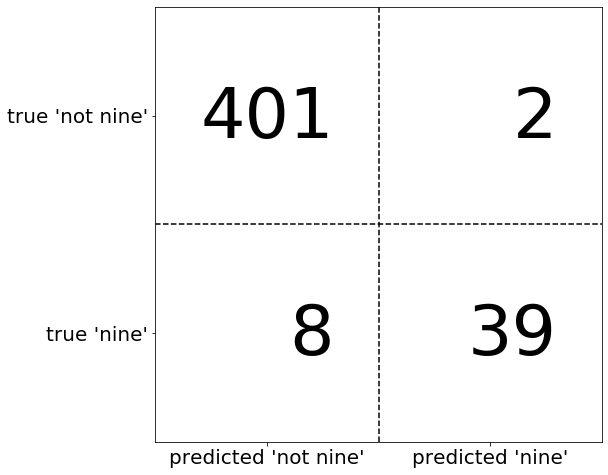

In [45]:
mglearn.plots.plot_confusion_matrix_illustration()

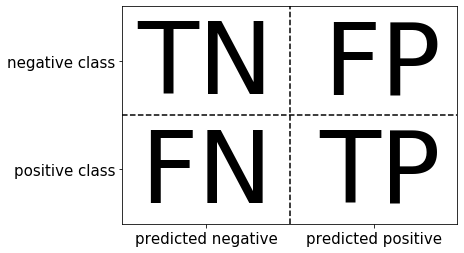

In [46]:
mglearn.plots.plot_binary_confusion_matrix()

In [47]:
print('빈도 기반 더미 모델:')
print(confusion_matrix(y_test, pred_most_frequent))
print('\n무작위 더미 모델:')
print(confusion_matrix(y_test, pred_dummy))
print('\n결정 트리: ')
print(confusion_matrix(y_test, pred_tree))
print('\n로지스틱 회귀: ')
print(confusion_matrix(y_test, pred_logreg))

빈도 기반 더미 모델:
[[403   0]
 [ 47   0]]

무작위 더미 모델:
[[364  39]
 [ 45   2]]

결정 트리: 
[[390  13]
 [ 24  23]]

로지스틱 회귀: 
[[401   2]
 [  8  39]]


1. 빈도 기반 더미 모델에서는 무조건 '9 아님' 이라고 예측했다.  
2. 무작위 더미 모델에서는 FP(43)과 FN(41)보다 TP(6)가 매우 적고, TP보다 FP(43)가 매우 많다.  
3. 결정 트리 모델에서는 더미 분류기보다 정상으로 보이지만, 정확도는 거의 비슷하다.  
4. 로지스틱 회귀는 모든 항목에서 트리 모델보다 잘 작동했다.

**이렇게 행렬의 모든 면을 살펴보면 많은 정보를 얻을 수 있지만, 매우 수동적이며 정성적인 방법이다.  
이어서 오차 행렬 정보를 요약할 수 있는 여러 방법을 알아보자**

## 정확도와의 관계

<img src=./img/Accuracy.png width=450 style=float:left>

<img src=./img/Precision.png width=450 style=float:left>

<img src=./img/Recall.png width=450 style=float:left>

재현율 최적화와 정밀도 최적화는 상충한다.  
따라서 정밀도와 재현율의 조화 평균인 f-score을 봐야한다.  
정밀도와 재현율을 같이 고려하므로 불균형한 이진 분류 데이터셋에서는 정확도보다 더 나은 지표가 될 수 있다.

<img src=./img/F-Score.png width=450 style=float:left>

In [48]:
#숫자 '9'가 양성 클래스이므로 양성 클래스가 소수(minority) 클래스이다.
from sklearn.metrics import f1_score
print('빈도 기반 더미 모델의 f1 score : {:.2f}'.format(f1_score(y_test, pred_most_frequent)))
print('무작위 더미 모델의 f1 score : {:.2f}'.format(f1_score(y_test, pred_dummy)))
print('트리 모델의 f1 score : {:.2f}'.format(f1_score(y_test, pred_tree)))
print('로지스틱 회귀 모델의 f1 score : {:.2f}'.format(f1_score(y_test, pred_logreg)))

빈도 기반 더미 모델의 f1 score : 0.00
무작위 더미 모델의 f1 score : 0.05
트리 모델의 f1 score : 0.55
로지스틱 회귀 모델의 f1 score : 0.89


1. 빈도 기반 더미 모델은 양성 클래스로 예측한 것이 없어서(분모가 0) 에러
2. 무작위 더미 모델과
3. 트리 모델 사이에서도 정확도에는 없던 뚜렷한 차이를 볼 수 있다.

In [49]:
#점수표를 깔끔하게 출력해주는 classification_report 함수 ...!!
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_most_frequent, target_names=['is not 9', '9']))

              precision    recall  f1-score   support

    is not 9       0.90      1.00      0.94       403
           9       0.00      0.00      0.00        47

    accuracy                           0.90       450
   macro avg       0.45      0.50      0.47       450
weighted avg       0.80      0.90      0.85       450



In [50]:
print(classification_report(y_test, pred_dummy, target_names=['is not 9', '9']))

              precision    recall  f1-score   support

    is not 9       0.89      0.90      0.90       403
           9       0.05      0.04      0.05        47

    accuracy                           0.81       450
   macro avg       0.47      0.47      0.47       450
weighted avg       0.80      0.81      0.81       450



In [51]:
print(classification_report(y_test, pred_tree, target_names=['is not 9', '9']))

              precision    recall  f1-score   support

    is not 9       0.94      0.97      0.95       403
           9       0.64      0.49      0.55        47

    accuracy                           0.92       450
   macro avg       0.79      0.73      0.75       450
weighted avg       0.91      0.92      0.91       450



In [52]:
print(classification_report(y_test, pred_logreg, target_names=['is not 9', '9']))

              precision    recall  f1-score   support

    is not 9       0.98      1.00      0.99       403
           9       0.95      0.83      0.89        47

    accuracy                           0.98       450
   macro avg       0.97      0.91      0.94       450
weighted avg       0.98      0.98      0.98       450



## 불확실성 고려
대부분의 분류기는 예측의 확신을 가늠하기 위한 decision_function이나 predict_proba 메서드를 제공한다.  
예측을 만들어내는 것은 decision_function이나 predict_proba 출력의 임계값을 검증하는 것이다.  
이진 탐색에서 decision_function은 0을, predict_proba는 0.5fmf dlarPrkqtdmfh tkdydgksek.

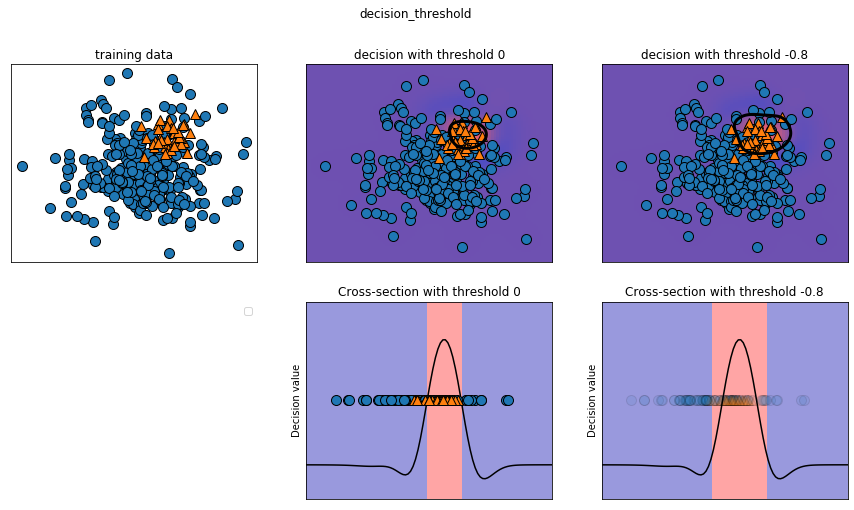

In [53]:
X, y = make_blobs(n_samples=(400,50), cluster_std=[7.0,2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
svc = SVC(gamma=.05).fit(X_train, y_train)

mglearn.plots.plot_decision_threshold()

In [54]:
print(classification_report(y_test, svc.predict(X_test)))
#Recall을 높이는게 중요하다고 생각해보자. 그러면 임계값을 바꿔 예측을 조정할 수 있다.

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       104
           1       0.35      0.67      0.46         9

    accuracy                           0.88       113
   macro avg       0.66      0.78      0.70       113
weighted avg       0.92      0.88      0.89       113



In [55]:
y_pred_lower_threshold = svc.decision_function(X_test) >-.8

In [56]:
print(classification_report(y_test, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       104
           1       0.32      1.00      0.49         9

    accuracy                           0.83       113
   macro avg       0.66      0.91      0.69       113
weighted avg       0.95      0.83      0.87       113



재현율보다 정밀도가 중요하거나 그 반대, 또는 데이터가 심하게 불균형일 때 결정 함수의 임계값을 바꾸면 더 나은 결과를 쉽게 얻을 수 있다. 

## 정밀도-재현율 곡선과 ROC 곡선
00% 재현율(Recall)처럼 분류기의 필요조건을 지정하는 것을 '운영 포인트(operating point)'를 지정한다고 말한다.  
새로운 모델을 만들 때는 운영 포인트가 명확하지 않은 경우가 많다.  
이런 경우에는 문제를 더 잘 이해하기 위해 모든 임계값을 조사해보거나, 한번에 정밀도나 재현율의 모든 장단점을 살펴보는 것이 좋다.  
이를 위해 '정밀도-재현율 곡선(precision-recall curve)'을 사용한다. 

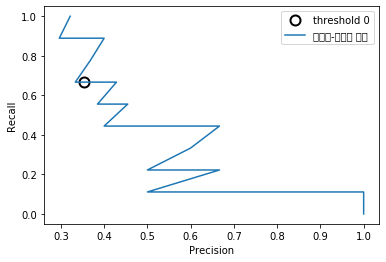

In [59]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

#0에 가까운 임계값을 찾는다.
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label = 'threshold 0', fillstyle ='none', c='k', mew=2)

plt.plot(precision, recall, label='정밀도-재현율 곡선')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')

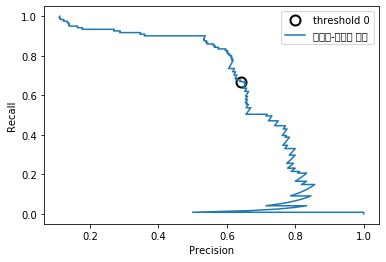

In [60]:
#부드러운 곡선을 위해 데이터 포인트 수 늘려 다시 확인하기
X,y = make_blobs(n_samples=(4000,500), cluster_std=[7.0,2], random_state=22)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

svc = SVC(gamma=.05).fit(X_train, y_train)

precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))

#0에 가까운 임계값을 찾는다.
close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label = 'threshold 0', fillstyle ='none', c='k', mew=2)

plt.plot(precision, recall, label='정밀도-재현율 곡선')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')

곡선의 각 포인트는 decision_function의 가능한 모든 임계값에 대응한다.  
예를 들어 정밀도가 약 0.75일 때의 재현율은 0.4이다. 검은 원은 decision_function의 기본 임계값인 0 지점을 나타낸다. 이 지점은 predict 메서드를 호출할 때 사용되는 임계값이다.  

곡선이 오른쪽 위로 갈수록 더 좋은 분류기이다(가장 볼록한 지점).   
임계값이 커지면서 곡선은 정밀도가 높아지는 쪽으로 이동하지만 재현율은 낮아진다. 정밀도가 높아져도 재현율이 높게 유지되는 것이 더 좋은 모델이다.   

분류기가 다르면 곡선의 다른 부분에서 장점이 생긴다. 즉 운영 포인트가 달라진다.

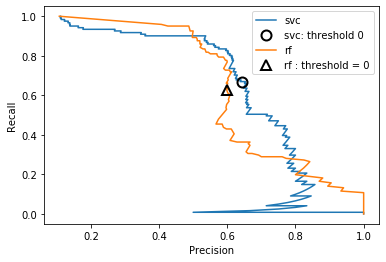

In [68]:
#랜덤포레스트와 SVM 비교. 랜덤포레스트는 decision_function을 제공하지 않고 predict_proba만 가지고 있다.
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators =100, random_state=0, max_features =2)
rf.fit(X_train, y_train)

#RandomForestClassifier는 predict_proba 제공
##precision_recall_curve는 양성 클래스(클래스1)의 확신에 대한 측정값을 두 번째 매개변수로 받는다.
###그래서 샘플이 클래스 1일 확률, 즉 rf.predict_proba(X_test)[:,1]을 넘긴다.
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:,1])

#svc의 precision_recall_curve
plt.plot(precision, recall, label='svc')

close_zero = np.argmin(np.abs(thresholds))
plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label = 'svc: threshold 0', 
         fillstyle ='none', c='k', mew=2)

#RandomForest의 precision_recall_curve
plt.plot(precision_rf, recall_rf, label='rf')

close_default_rf = np.argmin(np.abs(threshold_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c = 'k',
         markersize = 10, label = 'rf : threshold = 0', fillstyle = 'none', mew = 2)

plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')

그래프를 비교해보면 극단적인 부분, 즉 재현율이 매우 높거나 정밀도가 매우 높을 때는 랜덤 포레스트가 더 낫다는 것을 알 수 있다.  
가운데 근처(정밀도=0.7)에서는 SVM이 더 좋다.  
만약 f-score만으로 전체 성능을 비교한다면 이런 세세한 부분을 놓칠 수 있다. f-score는 정밀도-재현율 곡선의 한 지점인 기본 임계값에 대한 점수이기 때문에.

In [70]:
print('RandomForest f1_score: {:.3f}'.format(f1_score(y_test, rf.predict(X_test))))
print('SVC f1_score: {:.3f}'.format(f1_score(y_test, svc.predict(X_test))))

RandomForest f1_score: 0.610
SVC f1_score: 0.656


곡선을 비교하면 많은 통찰을 얻을 수 있지만 확실히 수작업이다. 모델을 자동으로 비교하려면 특정 임계값이나 운영 포인트에 국한하지 않고 전체 곡선에 담긴 정보를 요약해야 한다.  

이러한 요약 방법의 하나로 정밀도-재현율 곡선의 아랫부분 면적을 계산할 수 있으며, 이를 **'평균 정밀도(average precision)'** 라고 한다.

In [71]:
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, rf.predict_proba(X_test)[:,1])
ap_svc = average_precision_score(y_test, svc.decision_function(X_test))

print('RandomForest Average precision: {:.3f}'.format(ap_rf))
print('SVC Average precision: {:.3f}'.format(ap_svc))

#모든 임계값에 대해 평균을 내보면 랜덤 포레스트가 조금 낮지만, SVC와 거의 같은 성능이다.
##이는 앞서 본 f1_score의 결과와는 다른데,
###평균 정밀도는 0에서 1 사이를 지나는 곡선의 아래 면적이므로 항상 0(가장나쁨)과 1(가장 좋음) 사이의 값을 반환한다.

RandomForest Average precision: 0.660
SVC Average precision: 0.666


## ROC와 AUC
**ROC 곡선**  
여러 임계값에서 분류기의 특성을 분석하는 데 널리 사용하는 도구이다.  
모든 임계값을 고려하지만, 정밀도와 재현율 대신 진짜 양성 비율(TPR)(=Recall)에 대한 거짓 양성 비율(FPR)(=전체 음성 샘플 중 거짓 양성으로 잘못 분류한 비율)을 나타낸다.

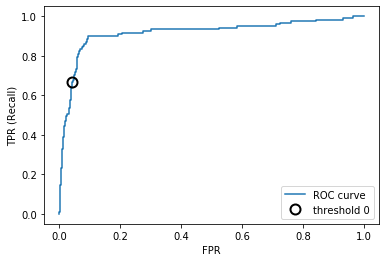

In [72]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))

plt.plot(fpr, tpr, label= 'ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')

#0 근처의 임계값을 찾는다.
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='threshold 0', fillstyle='none', c='k', mew=2)
plt.legend(loc=4)

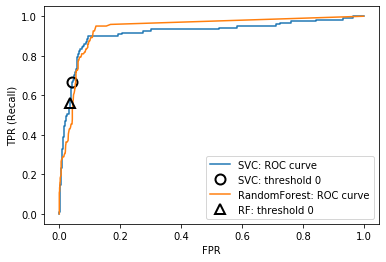

In [76]:
#랜덤 포레스트와 SVM의 ROC 곡선 비교
from sklearn.metrics import roc_curve
#SVC
fpr, tpr, thresholds = roc_curve(y_test, svc.decision_function(X_test))
plt.plot(fpr, tpr, label= 'SVC: ROC curve')

close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, label='SVC: threshold 0', fillstyle='none', c='k', mew=2)


#RandomForest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.plot(fpr_rf, tpr_rf, label= 'RandomForest: ROC curve')

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(fpr[close_default_rf], tpr[close_default_rf], '^', markersize=10, label='RF: threshold 0', fillstyle='none', c='k', mew=2)

plt.xlabel('FPR')
plt.ylabel('TPR (Recall)')
plt.legend(loc=4)

In [77]:
#곡선 아래의 면적값 하나로 ROC 곡선을 요약할 때가 많다. AUC(Area Under Curve)
from sklearn.metrics import roc_auc_score
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
svc_auc = roc_auc_score(y_test, svc.decision_function(X_test))

print('RandomForest AUC: {:.3f}'.format(rf_auc))
print('SVC AUC: {:.3f}'.format(svc_auc))

RandomForest AUC: 0.937
SVC AUC: 0.916


AUC가 0과 1 사이의 곡선 아래 면적이므로 항상 0(최악)과 1(최선) 사이의 값을 가진다.  

데이터셋에 담긴 클래스가 아무리 불균형하더라도 무작위로 예측한 AUC 값은 0.5가 된다. 그래서 불균형한 데이터셋에서는 정확도보다 AUC가 훨씬 좋은 지표이다. 

AUC는 양성 샘플의 순위를 평가하는 것으로 볼 수 있다. 이는 분류기에서 무작위로 선택한 양성 클래스 포인트의 점수가 무작위로 선택한 음성 클래스 포인트의 점수보다 높을 확률과 같다. 그래서 AUC가 1일 때는 모든 양성 포인트의 점수가 모든 음성 포인트의 점수보다 높다. 

gamma = 1.00, Accuracy = 0.90, AUC = 0.50
gamma = 0.10, Accuracy = 0.90, AUC = 0.96
gamma = 0.01, Accuracy = 0.90, AUC = 1.00


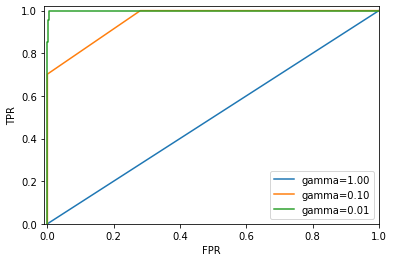

In [78]:
y= digits.target ==9

X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state =0)

plt.figure()

for gamma in [1, 0.1, 0.01]:
    svc = SVC(gamma=gamma).fit(X_train, y_train)
    accuracy = svc.score(X_test, y_test)
    auc = roc_auc_score(y_test, svc.decision_function(X_test))
    fpr, tpr, _ = roc_curve(y_test, svc.decision_function(X_test))
    
    print('gamma = {:.2f}, Accuracy = {:.2f}, AUC = {:.2f}'.format(gamma, accuracy, auc) )
    
    plt.plot(fpr, tpr, label='gamma={:.2f}'.format(gamma))
    
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim(-0.01, 1)
plt.ylim(0, 1.02)

plt.legend(loc='best')

세 가지 gamma 값에 대한 정확도는 90%로 모두 같다. 그러나 AUC와 ROC 곡선을 보면 세 모델의 차이가 뚜렷하게 확인된다.  
gamma =1.0에서 AUC는 무작위로 선택한 수준, 즉 decision_function의 출력이 무작위 선택과 다를 바가 없다.  
gamma = 0.1 에서는 AUC 값이 0.96으로 크게 향상되었다. 
gamma = 0.01 에서는 AUC 값이 완벽한 1의 값을 얻었다.

즉 결정 함수에 의해서 모든 양성 포인트는 어떤 음성 포인트보다 더 높은 점수를 가진다. 다르게 말해 적절한 임계값에서 이 모델은 데이터를 완벽하게 분류할 수 있다. 이 사실은 이 모델에서 임계값을 조정해서 아주 높은 예측 성능을 얻을 수 있음을 말해준다. 정확도만 사용한다면 이런 점을 결코 발견하지 못할 것이다.

이런 이유로 불균형한 데이터셋에서 모델을 평가할 때는 AUC를 사용하라고 강력히 권한다. 하지만 AUC 값이 기본 임계값과는 상관없으므로, AUC가 높은 모델에서 좋은 분류 결과를 얻으려면 결정 임계값을 조정해야 한다.

# 5.3.3 다중 분류의 평가 지표

In [80]:
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, random_state=0)

lr = LogisticRegression(solver = 'liblinear', multi_class='ovr').fit(X_train, y_train)
pred = lr.predict(X_test)

print('Accuracy : {:.3f}'.format(accuracy_score(y_test, pred)))
print('\nConfusion Metrix: \n', confusion_matrix(y_test, pred))

Accuracy : 0.953

Confusion Metrix: 
 [[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  2  0]
 [ 0  0 41  3  0  0  0  0  0  0]
 [ 0  0  1 43  0  0  0  0  0  1]
 [ 0  0  0  0 38  0  0  0  0  0]
 [ 0  1  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0 52  0  0  0]
 [ 0  1  0  1  1  0  0 45  0  0]
 [ 0  3  1  0  0  0  0  0 43  1]
 [ 0  0  0  1  0  1  0  0  1 44]]


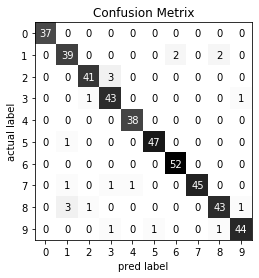

In [82]:
score_image = mglearn.tools.heatmap(confusion_matrix(y_test, pred), xlabel='pred label', ylabel='actual label',
                                   xticklabels=digits.target_names, yticklabels=digits.target_names, cmap=plt.cm.gray_r, fmt='%d')
plt.title('Confusion Metrix')
plt.gca().invert_yaxis()

In [83]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.89      0.91      0.90        43
           2       0.95      0.93      0.94        44
           3       0.90      0.96      0.92        45
           4       0.97      1.00      0.99        38
           5       0.98      0.98      0.98        48
           6       0.96      1.00      0.98        52
           7       1.00      0.94      0.97        48
           8       0.93      0.90      0.91        48
           9       0.96      0.94      0.95        47

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



다중 분류에서 불균형 데이터셋을 위해 가장 널리 사용하는 평가 지표는 f-score의 다중 분류 버전이다.  
다중 클래스용  f-score는 한 클래스를 양성 클래스로 두고 나머지 클래스들을 음성 클래스로 간주하여 클래스마다 f-score를 계산한다. 그런 다음, 클래스별 f-score 를 다음 전략 중 하나를 사용하여 평균을 낸다.

- 'macro'평균 : 클래스별 f-score에 가중치를 주지 않는다. 클래스 크기에 상관없이 모든 클래스를 같은 비중으로 다룬다.
- 'weighted' 평균: 클래스별 샘플 수로 가중치를 두어 f-score 평균을 계산한다.
- 'micro' 평균: 모든 클래스의 거짓 양성(FP), 거짓 음성(FN), 진짜 양성(TP)의 총 수를 헤아린 다음 정밀도, 재현율, f-score를 이 수치로 계산한다.

각 샘플을 똑같이 간주한다면 'micro' 평균 f-score를 추천, 각 클래스를 동일한 비중으로 고려한다면 'macro'평균 f-score 추천

In [84]:
print('micro 평균 f1_scoe: {:.3f}'.format(f1_score(y_test, pred, average='micro')))
print('macro 평균 f1_score: {:.3f}'.format(f1_score(y_test, pred, average='macro')))

micro 평균 f1_scoe: 0.953
macro 평균 f1_score: 0.954


# 5.3.4 회귀의 평가 지표
대부분의 애플리케이션에서는 회귀 추정기의 score 메서드에서 이용하는 R^2 만으로 충분하다.

# 5.3.5 모델 선택에서 평가 지표 사용하기
GridSearchCV나 cross_val_score를 사용하여 모델을 선택할 때, AUC 같은 평가 지표를 사용할 수 있다.
scoring 매개변수를 통해 손쉽게 이를 구현했다.

In [86]:
#분류의 기본 평가 지표는 정확도
print('기본 평가 지표: ', cross_val_score(SVC(), digits.data, digits.target==9, cv=5))

#scoring='accuracy'의 결과는 같다.
explicit_accuracy = cross_val_score(SVC(), digits.data, digits.target==9, scoring='accuracy', cv=5)
print('정확도 지표: ', explicit_accuracy)

roc_auc = cross_val_score(SVC(), digits.data, digits.target==9, scoring='roc_auc', cv=5)
print('평균 정밀도 지표: ', roc_auc)

기본 평가 지표:  [0.9        0.9        0.89972145 0.89972145 0.89972145]
정확도 지표:  [0.9        0.9        0.89972145 0.89972145 0.89972145]
평균 정밀도 지표:  [0.99674211 0.99725652 0.99552804 0.99836601 0.99165807]


In [87]:
res = cross_validate(SVC(), digits.data, digits.target == 9, scoring=['accuracy', 'roc_auc', 'recall_macro'],
                    return_train_score=True, cv=5)
display(pd.DataFrame(res))

,fit_time,score_time,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc,test_recall_macro,train_recall_macro
0,0.351501,0.156257,0.900000,1.0,0.996742,1.0,0.5,1.0
1,0.298817,0.237234,0.900000,1.0,0.997257,1.0,0.5,1.0
2,0.266094,0.140612,0.899721,1.0,0.995528,1.0,0.5,1.0
3,0.317738,0.207137,0.899721,1.0,0.998366,1.0,0.5,1.0
4,0.286934,0.156236,0.899721,1.0,0.991658,1.0,0.5,1.0


In [92]:
#GridSearchCV에서도 평가지표 바꿀 수 있다. 
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target==9, random_state=0)

#일부러 적절하지 않은 그리드를 만든다
param_grid = {'gamma': [0.0001, 0.01, 0.1, 1, 10]}

#기본 정확도 측정 지표를 사용
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=3)
grid.fit(X_train, y_train)

print('<정확도 지표를 사용한 그리드 서치>')
print('Best Parmeter: ', grid.best_params_)
print('최상의 교차 검증 점수(정확도): {:.3f}'.format(grid.best_score_))

print('테스트 세트 평균 정밀도: {:.3f}'.format(average_precision_score(y_test, grid.decision_function(X_test))))
print('테스트 세트 정확도: {:.3f}'.format(grid.score(X_test, y_test)))

<정확도 지표를 사용한 그리드 서치>
Best Parmeter:  {'gamma': 0.0001}
최상의 교차 검증 점수(정확도): 0.970
테스트 세트 평균 정밀도: 0.966
테스트 세트 정확도: 0.973


In [93]:
#평균 정밀도 지표 사용
grid = GridSearchCV(SVC(), param_grid=param_grid, scoring = 'average_precision', cv=3)
grid.fit(X_train, y_train)

print('<AUC 지표를 사용한 그리드 서치>')
print('Best Parmeter: ', grid.best_params_)
print('최상의 교차 검증 점수(정확도): {:.3f}'.format(grid.best_score_))

print('테스트 세트 평균 정밀도: {:.3f}'.format(average_precision_score(y_test, grid.decision_function(X_test))))
print('테스트 세트 정확도: {:.3f}'.format(grid.score(X_test, y_test)))

<AUC 지표를 사용한 그리드 서치>
Best Parmeter:  {'gamma': 0.01}
최상의 교차 검증 점수(정확도): 0.985
테스트 세트 평균 정밀도: 0.996
테스트 세트 정확도: 0.996


평가 지표에 따라 gamma가 달라진다. 평균 정밀도를 최적화하기 위해 찾은 매개변수에서는 테스트 세트의 평균 정밀도가 더 높다. 반면 정확도를 최적화하기 위해 찾은 매개변수에서는 테스트 세트의 정확도가 더 높다.

분류문제 scoring 매개변수
- accuracy(default),
- roc_auc : ROC 곡선 아래 면적
- average_precision : 정확도-재현율 곡선 아래 면적
- f1_macro / f1_micro / f1_weighted

회귀문제 scoring 매개변수
- r2 : R^2
- mean_squared_error
- mean_absolute_error

In [94]:
from sklearn.metrics.scorer import SCORERS
print('가능한 평가 방식:\n', sorted(SCORERS.keys()))

가능한 평가 방식:
 ['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'brier_score_loss', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'max_error', 'mutual_info_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'normalized_mutual_info_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'v_measure_score']
